In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
barcodes = pd.read_excel('Data/qPCR/NxW MinION master list.xlsx', sheet_name = 'Index PCR', engine='openpyxl')
barcodes = barcodes[barcodes['Study'] == 'NxW_16S']
barcodes = barcodes[~barcodes['Barcode'].isnull()]
barcodes = barcodes[['Sample name', 'Barcode','Notes']].set_index('Sample name')
barcodes.head()

,Barcode,Notes
Sample name,,
2,1.0,NxW_A library
6,2.0,NxW_A library
15,3.0,NxW_A library
16,4.0,NxW_A library
19,5.0,NxW_A library


In [4]:
plot_key = pd.read_excel('Data/ID and Plots.xlsx', engine='openpyxl')
plot_key.head()

,ID,Plot,Nitrogen,Water,Block,Water rate (%ET),Nrate (llbs/acre)
0,111,2N,1,1,1,100,20
1,111,2S,1,1,1,100,20
2,112,5N,2,1,1,100,65
3,112,5S,2,1,1,100,65
4,113,4N,3,1,1,100,110


In [5]:
soil_key = pd.read_excel('Data/Soil key/Soil DNA extraction key.xlsx', engine='openpyxl')
soil_key = soil_key[soil_key['Skipping'] != 'Yes']
soil_key = soil_key[soil_key['Quality'] != 'Failed']
soil_key = soil_key[['Sample name', 'Sample date', 'Plot']]
soil_key.rename({'Plot':'Sample ID'}, axis = 1, inplace = True)
soil_key = soil_key[~soil_key['Sample ID'].isnull()]
soil_key[['Plot', 'ID', 'Nitrogen', 'Water', 'Block', 'Direction']] = np.nan
soil_key_nxwater = soil_key.copy()
for index, row in soil_key.iterrows():
    if (row['Sample ID'] == 'King Fischer') | (row['Sample ID'] == 'stove pipe prairie') | (row['Sample ID'] == 'NaN'):
        continue
    tmp_data = plot_key[plot_key['Plot'] == row['Sample ID']]
    soil_key_nxwater.loc[index, 'Plot'] = tmp_data['Plot'].iloc[0]
    soil_key_nxwater.loc[index, 'ID'] = tmp_data['ID'].iloc[0]
    soil_key_nxwater.loc[index, 'Block'] = tmp_data['Block'].iloc[0]
    soil_key_nxwater.loc[index, 'Water'] = tmp_data['Water'].iloc[0]
    soil_key_nxwater.loc[index, 'Nitrogen'] = tmp_data['Nitrogen'].iloc[0]
soil_key_nxwater['Direction'] = [x[-1:] for x in soil_key['Sample ID']]
# soil_key_nxwater['Sample date'] = [x.strftime('%m-%d') for x in soil_key['Sample date']]
soil_key_nxwater = soil_key_nxwater[soil_key_nxwater['Nitrogen'].isin([1,5,6])]
soil_key_nxwater.set_index('Sample name', inplace = True)
soil_key_nxwater.head()

,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction
Sample name,,,,,,,,
2,2021-07-27,15N,15N,225.0,5.0,2.0,2.0,N
6,2021-07-27,32N,32N,311.0,1.0,1.0,3.0,N
15,2021-07-27,8N,8N,121.0,1.0,2.0,1.0,N
16,2021-07-27,2S,2S,111.0,1.0,1.0,1.0,S
19,2021-07-27,30N,30N,321.0,1.0,2.0,3.0,N


In [6]:
set(soil_key_nxwater['Sample date'])

{Timestamp('2021-06-15 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-07-27 00:00:00'),
 Timestamp('2021-08-10 00:00:00'),
 Timestamp('2021-09-23 00:00:00'),
 Timestamp('2022-05-26 00:00:00'),
 Timestamp('2022-06-22 00:00:00'),
 Timestamp('2022-07-20 00:00:00'),
 Timestamp('2022-09-01 00:00:00'),
 Timestamp('2022-09-27 00:00:00')}

In [7]:
samples_df = soil_key_nxwater[['Sample date','Nitrogen','Water','ID']].groupby(['Sample date','Nitrogen','Water']).count()
print(samples_df['ID'].sum())
samples_df.to_csv('Output/samples_sequenced.csv')
samples_df.head(n = 10)

245


ID
Sample date Nitrogen Water    
2021-06-15  1.0      1.0     6
                     2.0     5
            5.0      1.0     6
                     2.0     6
            6.0      1.0     6
                     2.0     6
2021-06-30  1.0      1.0     5
                     2.0     6
            5.0      1.0     4
                     2.0     6

# Reading in raw EMU files and formatting

In [8]:
import glob
import os

In [9]:
# Define the directory containing the run folders
bacteria_dir = 'Bacteria'

# Define the run folders
run_folders = ['Run_A', 'Run_B', 'Run_C']

# Create a dictionary to hold the DataFrames for each run
dataframes = {}

# Iterate through each run folder
for run_folder in run_folders:
    # Extract the run identifier (assuming it's the last character of the run_folder name)
    run_id = run_folder[-1]
    
    # Construct the path to the run folder
    run_dir = os.path.join(bacteria_dir, run_folder)
    print(f'Processing: {run_dir}')

    # Get the list of files within the run folder
    filenames = sorted(glob.glob(f"{run_dir}/*rel-abundance.tsv"))

    # Initialize a counter for each run
    counter = 0

    # Process each file within the run folder
    for filename in filenames:
        counter += 1
        temp = pd.read_csv(filename, sep='\t', header=0)
        barcode = os.path.basename(filename).split('.')[0]
        temp.rename(columns={"abundance": barcode}, inplace=True)
        names = temp[['phylum', 'class', 'order', 'family', 'genus', 'species', 'tax_id']]
        tDict = names.set_index('tax_id').T.to_dict('list')
        abund = temp[[barcode, 'tax_id']]
        if counter == 1:
            df = abund
            tax = tDict
        else:
            df = df.merge(abund, how='outer', on='tax_id')
            tax = {**tax, **tDict}

    # Save the DataFrame for the current run to the dictionary
    dataframes[f'rel_abund{run_id}'] = df.merge(
        pd.DataFrame.from_dict(tax, orient='index', columns=['phylum', 'class', 'order', 'family', 'genus', 'species']).reset_index().rename(columns={'index': 'tax_id'}),
        how='outer',
        on='tax_id'
    )

Processing: Bacteria/Run_A
Processing: Bacteria/Run_B
Processing: Bacteria/Run_C


In [10]:
# Extract the DataFrames from the dictionary
rel_abund_A = dataframes['rel_abundA']
rel_abund_B = dataframes['rel_abundB']
rel_abund_C = dataframes['rel_abundC']

# Define a function to process a DataFrame as per your original logic
def process_dataframe(df, run_id):
    df['superkingdom'] = 'Bacteria'
    df = df.groupby(['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'tax_id']).sum()
    print(f'{run_id} total species: ', len(df))
    df.columns = [x + run_id for x in df.columns]
    return df.reset_index()

# Apply the function to each DataFrame
rel_abund_A = process_dataframe(rel_abund_A, 'A')
rel_abund_B = process_dataframe(rel_abund_B, 'B')
rel_abund_C = process_dataframe(rel_abund_C, 'C')

# Display the head of the DataFrame for run A
rel_abund_A.head()

A total species:  797
B total species:  1366
C total species:  2607


,superkingdom,phylum,class,order,family,genus,species,tax_id,barcode01A,barcode02A,...,barcode86A,barcode87A,barcode88A,barcode89A,barcode90A,barcode91A,barcode92A,barcode93A,barcode95A,barcode96A
0,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidicapsa,Acidicapsa acidisoli,1615681,0.0,0.001207,...,0.002802,0.000000,0.0,0.001807,0.0,0.000000,0.0,0.0,0.0,0.0
1,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidipila,Acidipila dinghuensis,1560006,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidipila,Acidipila rosea,768535,0.0,0.002582,...,0.003641,0.005891,0.0,0.000000,0.0,0.007891,0.0,0.0,0.0,0.0
3,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidisarcina,Acidisarcina polymorpha,2211140,0.0,0.002166,...,0.004232,0.003585,0.0,0.003742,0.0,0.000000,0.0,0.0,0.0,0.0
4,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidobacterium,Acidobacterium capsulatum,33075,0.0,0.000000,...,0.000000,0.000000,0.0,0.002165,0.0,0.000000,0.0,0.0,0.0,0.0


In [11]:
rel_abund_AB = pd.merge(rel_abund_A, rel_abund_B, how='outer', on = ['superkingdom','phylum','class','order','family','genus','species','tax_id'])
print('AB total species: ', len(rel_abund_AB))
rel_abund_ABC = pd.merge(rel_abund_AB, rel_abund_C, how='outer', on = ['superkingdom','phylum','class','order','family','genus','species','tax_id'])
print('ABC total species: ', len(rel_abund_ABC))
print('ABC shape: ', rel_abund_ABC.shape)

AB total species:  1453
ABC total species:  2757
ABC shape:  (2757, 272)


In [13]:
rel_abund_ABC.to_csv('rel_abund_16S_ABC.csv')

# Positive control quality report

In [11]:
import matplotlib.pyplot as plt

In [12]:
zymo_true_species = pd.DataFrame(index = ['Zymo'], data = {'Bacillus subtilis': [17.4], 'Enterococcus faecalis': [9.9], 
                                                           'Escherichia coli':[10.1],
                                                    'Limosilactobacillus fermentum':[18.4], 'Listeria monocytogenes': [14.1], 
                                                           'Pseudomonas aeruginosa': [4.2],
                                                   'Salmonella enterica': [10.4], 'Staphylococcus aureus': [15.5]})
zymo = rel_abund_ABC[['species', 'barcode96A', 'barcode96B', 'barcode96C']]

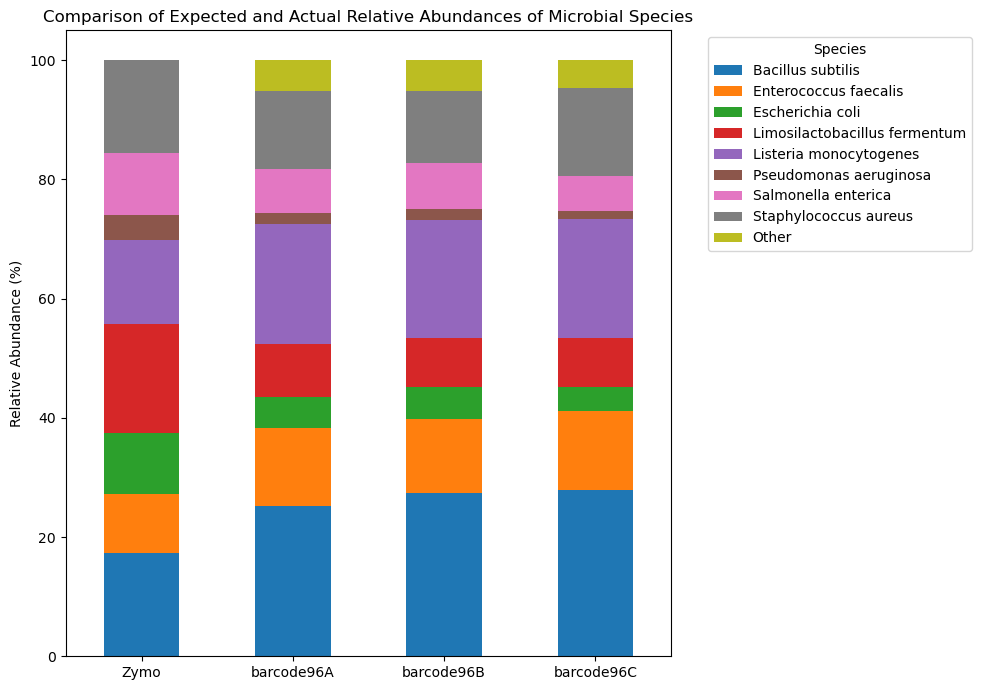

In [13]:
# Aggregating the actual data
zymo_agg = zymo.groupby('species').sum().transpose()

# Separating known and unknown species
known_species = zymo_agg[zymo_true_species.columns].fillna(0)
unknown_species = zymo_agg.drop(columns=zymo_true_species.columns, errors='ignore').sum(axis=1)
all_known_unknown = pd.concat([known_species, unknown_species.rename('Other')], axis=1)

# Concatenating the expected and actual data
all_data = pd.concat([zymo_true_species, all_known_unknown])

# Normalizing data to obtain relative abundance (percentage)
all_data_normalized = all_data.div(all_data.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
all_data_normalized.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('Relative Abundance (%)')
ax.set_title('Comparison of Expected and Actual Relative Abundances of Microbial Species')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.tight_layout()

# Negative control quality report

In [8]:
total_reads = pd.read_excel('Data/Reads/bacterial_demultiplex_log.xlsx', sheet_name = 'All', engine='openpyxl')
total_reads['Barcode'] = total_reads['sample'] + total_reads['run']
total_reads.tail()

,sample,reads,f,ft,ftu,ftuc,final,run,Barcode
283,barcode92,0,0,0,0,0,0,C,barcode92C
284,barcode93,11,11,11,11,11,11,C,barcode93C
285,barcode94,0,0,0,0,0,0,C,barcode94C
286,barcode95,81549,79510,79432,79432,79432,79432,C,barcode95C
287,barcode96,181095,179310,179139,179139,179139,179139,C,barcode96C


In [9]:
# DNA extraction blank barcode22C
# MinION H20 = barcode93A, barcode94A, barcode93B, barcode94B, barcode93C, barcode94C
# List of negative control sample barcodes
negative_control_barcodes = ['barcode22C', 'barcode30B', 'barcode93A', 'barcode94A', 'barcode93B', 'barcode94B', 'barcode93C', 'barcode94C']

# Initialize an empty dictionary to store the total reads for each negative control sample
negative_control_reads = {}

# Loop through each negative control barcode and sum the 'final' column values
for barcode in negative_control_barcodes:
    filtered_data = total_reads[total_reads['Barcode'].str.contains(barcode, na=False)]
    total_reads_for_barcode = filtered_data['final'].sum()
    negative_control_reads[barcode] = total_reads_for_barcode

# Convert the dictionary to a DataFrame for better visualization
negative_control_reads_df = pd.DataFrame(list(negative_control_reads.items()), columns=['Barcode', 'Total Reads'])

negative_control_reads_df.to_csv('Output/negative_conrtols.csv')
# Display the DataFrame
negative_control_reads_df

,Barcode,Total Reads
0,barcode22C,0
1,barcode30B,3423
2,barcode93A,159
3,barcode94A,0
4,barcode93B,18575
5,barcode94B,0
6,barcode93C,11
7,barcode94C,0


# Total reads report

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Total Reads per Sequencing Run')

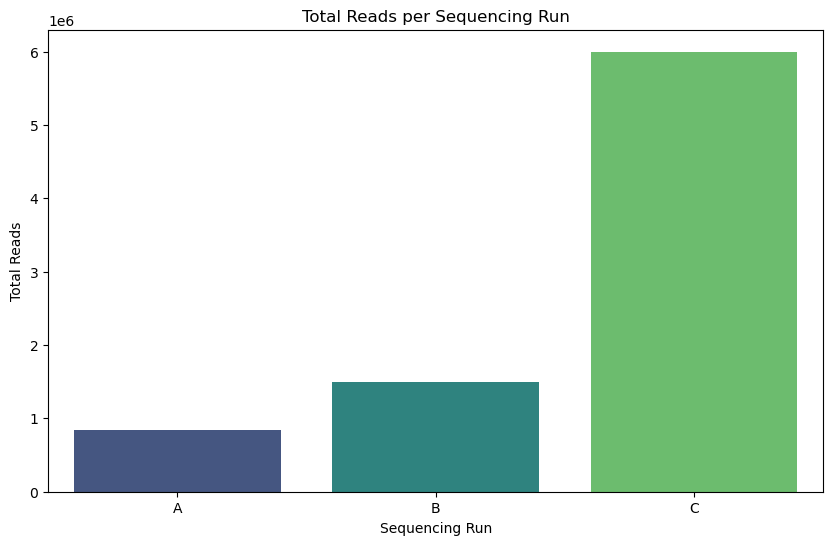

In [16]:
# Summing the final reads for each sequencing run
reads_per_run = total_reads.groupby('run')['final'].sum().reset_index()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=reads_per_run, x='run', y='final', palette='viridis')

# Adding labels and title
plt.xlabel('Sequencing Run')
plt.ylabel('Total Reads')
plt.title('Total Reads per Sequencing Run')

In [18]:
total_reads.columns.values

array(['sample', 'reads', 'f', 'ft', 'ftu', 'ftuc', 'final', 'run',
       'Barcode'], dtype=object)

In [21]:
sum_total_reads = total_reads[['reads', 'f', 'ft', 'ftu', 'ftuc', 'final']].sum()
sum_total_reads

reads    8669048
f        8343050
ft       8330317
ftu      8330317
ftuc     8330317
final    8330317
dtype: int64

In [23]:
sum_total_reads['reads'] - sum_total_reads['f']

325998

In [24]:
sum_total_reads['f'] - sum_total_reads['ft']

12733

In [25]:
sum_total_reads['final']/len(total_reads)

28924.711805555555

# Adjusting qpcr
Samples were analyzed with typical MinION EMU pipeline

In [18]:
qpcr = pd.read_csv('mapping_file_with_metadata_harvest_biomass_2022.csv', index_col=0)
qpcr = qpcr[['Barcode_key','qPCR_DW']]
qpcr.head()

,Barcode_key,qPCR_DW
0,barcode53B,6.543419e+08
1,barcode65B,4.302857e+08
2,barcode72B,7.121023e+08
3,barcode81B,9.019337e+08
4,barcode55B,6.264390e+08


In [19]:
# Ensure the data is correctly formatted and the necessary columns exist
assert 'Barcode_key' in qpcr.columns, "Barcode_key column not found in qpcr DataFrame"
assert 'qPCR_DW' in qpcr.columns, "qPCR_DW column not found in qpcr DataFrame"

# Create a copy of the rel_abund_ABC DataFrame to hold the adjusted values
rel_abund_ABC_adj = rel_abund_ABC.copy()

# List of non-barcode columns that should not be included in the multiplication
non_barcode_columns = ['tax_id', 'class', 'species', 'genus', 'family', 'order', 'phylum', 'superkingdom']

# Create a list to hold columns to be dropped
columns_to_drop = []

# Iterate through each column in rel_abund_ABC_adj, skipping the non-barcode columns
for column in rel_abund_ABC_adj.columns:
    if column not in non_barcode_columns:
        # Check if the barcode exists in the qpcr DataFrame
        if column in qpcr['Barcode_key'].values:
            # Get the multiplication factor from the qpcr DataFrame
            factor = qpcr[qpcr['Barcode_key'] == column]['qPCR_DW'].values[0]
            # Perform the multiplication
            rel_abund_ABC_adj[column] = rel_abund_ABC_adj[column] * factor
        else:
            # Add the column to the list of columns to be dropped
            columns_to_drop.append(column)
            print(f"Warning: Barcode {column} not found in qpcr DataFrame. Column will be dropped.")

# Drop the columns that are not present in qpcr DataFrame
rel_abund_ABC_adj.drop(columns_to_drop, axis=1, inplace=True)

# Now rel_abund_ABC_adj should have the adjusted values with the unmatched columns removed

In [20]:
rel_abund_ABC_adj.to_csv('rel_abund_16S_ABC_qpcr_adj.csv', index=False)
print(rel_abund_ABC_adj.shape)
rel_abund_ABC_adj.head()

(2757, 250)


,superkingdom,phylum,class,order,family,genus,species,tax_id,barcode01A,barcode02A,...,barcode74C,barcode75C,barcode76C,barcode77C,barcode78C,barcode79C,barcode80C,barcode81C,barcode82C,barcode83C
0,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidicapsa,Acidicapsa acidisoli,1615681,0.0,1.055384e+06,...,857802.811342,1.121190e+06,978671.746311,493797.250269,938920.343210,742209.533199,770776.080205,1.017473e+06,1.502890e+06,8.305518e+05
1,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidipila,Acidipila dinghuensis,1560006,0.0,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.469376e+05,0.000000e+00
2,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidipila,Acidipila rosea,768535,0.0,2.257000e+06,...,203327.397339,6.785389e+05,604839.067803,345019.980484,550435.981115,214920.925431,251103.313507,4.881221e+05,1.769138e+06,6.830290e+05
3,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidisarcina,Acidisarcina polymorpha,2211140,0.0,1.893570e+06,...,455583.923325,3.551638e+05,708809.490731,419313.861075,339481.427662,339504.182839,503021.790346,6.183139e+05,3.596255e+06,1.370849e+06
4,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidobacterium,Acidobacterium capsulatum,33075,0.0,0.000000e+00,...,787910.901972,5.123622e+05,636440.940573,629812.574860,408283.907354,458627.986637,777068.834027,6.308132e+05,1.633637e+06,5.328800e+05


# Combining mapping file and sequences

In [21]:
mapping_file = pd.read_csv('mapping_file_with_metadata_harvest_biomass_2022.csv')
print(set(mapping_file['Barcode_key']) - set(rel_abund_ABC_adj.columns))
print(set(rel_abund_ABC_adj.columns) - set(mapping_file['Barcode_key']))

{'barcode39B', 'barcode69A'}
{'class', 'phylum', 'tax_id', 'genus', 'superkingdom', 'order', 'family', 'species'}


In [27]:
# Copy rel_abund_ABC_adj dataframe
rel_abund_ABC_adj_copy = rel_abund_ABC_adj.copy()

# Drop non-barcode columns from rel_abund_ABC_adj_copy
non_barcode_columns = ['tax_id', 'class', 'genus', 'family', 'order', 'phylum', 'superkingdom']
rel_abund_ABC_adj_copy.drop(non_barcode_columns, axis=1, inplace=True)

# Set 'species' as the index
rel_abund_ABC_adj_copy.set_index('species', inplace=True)

# Transpose rel_abund_ABC_adj_copy
rel_abund_ABC_adj_T = rel_abund_ABC_adj_copy.T.fillna(0)

# Adding Bacteria to column names
rel_abund_ABC_adj_T.columns = ['Bacteria ' + x for x in rel_abund_ABC_adj_T.columns]

# Ensure 'Barcode_key' is set as a column in mapping_file
if 'Barcode_key' not in mapping_file.columns:
    mapping_file['Barcode_key'] = mapping_file.index

# Perform an inner join on 'Barcode_key'
merged_df = mapping_file.merge(rel_abund_ABC_adj_T, left_on='Barcode_key', right_index=True, how='inner')

# Check the first few rows of the merged dataframe
merged_df.to_csv('mapping_file_taxonomy.csv')
print(merged_df.shape)
merged_df.head()

(242, 2799)


,Unnamed: 0,Sample name,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,...,Bacteria Fervidobacterium nodosum,Bacteria Fervidobacterium pennivorans,Bacteria Methylacidiphilum fumariolicum,Bacteria Methylacidiphilum kamchatkense,Bacteria Cephaloticoccus primus,Bacteria Lacunisphaera anatis,Bacteria Haloferula sargassicola,Bacteria Luteolibacter arcticus,Bacteria Prosthecobacter vanneervenii,Bacteria Roseibacillus persicicus
0,0,193,2021-06-15,2N,2N,111.0,Low,High,1,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,205,2021-06-15,2S,2S,111.0,Low,High,1,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,212,2021-06-15,23S,23S,211.0,Low,High,2,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,221,2021-06-15,23N,23N,211.0,Low,High,2,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,195,2021-06-15,32N,32N,311.0,Low,High,3,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# For brute force analysis of grain yield and microbes

In [60]:
print(merged_df.shape)
# Filtering to just date with grain measurements
brute_force_df = merged_df[merged_df['Sample date'] == '2021-09-23']
print(brute_force_df.shape)

# Dropping empty columns
cols_bacteria = [col for col in brute_force_df.columns if 'Bacteria' in col]
zero_sum_cols = brute_force_df[cols_bacteria].sum() == 0
cols_to_drop = zero_sum_cols.index[zero_sum_cols]
brute_force_df.drop(columns=cols_to_drop, inplace=True)
print(brute_force_df.shape)

# Renaming columns for easier computation
cols_bacteria = [col for col in brute_force_df.columns if 'Bacteria' in col]
replacement_dict = {col: col.replace(' ', '_').replace('/', '.') for col in cols_bacteria}
brute_force_df.rename(columns=replacement_dict, inplace=True)

brute_force_df.to_csv('SCINet/brute_force_df.csv')
brute_force_df.head()

(242, 2799)
(31, 2799)
(31, 706)


/tmp/ipykernel_4862/3213686823.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brute_force_df.drop(columns=cols_to_drop, inplace=True)
/tmp/ipykernel_4862/3213686823.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brute_force_df.rename(columns=replacement_dict, inplace=True)


,Unnamed: 0,Sample name,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,...,Bacteria_Legionella_saoudiensis,Bacteria_Legionella_tunisiensis,Bacteria_Dyella_humi,Bacteria_Frateuria_terrea,Bacteria_Luteibacter_rhizovicinus,Bacteria_Rhodanobacter_caeni,Bacteria_Rhodanobacter_fulvus,Bacteria_Rhodanobacter_ginsenosidimutans,Bacteria_Rhodanobacter_lindaniclasticus,Bacteria_Stenotrophomonas_maltophilia
137,137,180,2021-09-23,2S,2S,111.0,Low,High,1,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,138,92,2021-09-23,2N,2N,111.0,Low,High,1,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,139,68,2021-09-23,32N,32N,311.0,Low,High,3,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,140,186,2021-09-23,3S,3S,115.0,Optimal,High,1,S,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,141,85,2021-09-23,3N,3N,115.0,Optimal,High,1,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
